In [1]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load data

In [3]:
df = pd.read_csv("/kaggle/input/mrbeast-youtube-comment-sentiment-analysis/sentiment_analysis_dataset.csv", sep=',', quotechar='"', engine='python', on_bad_lines='skip')

In [4]:
df.head()

,Comment,Sentiment
0,Achieving million views in days is dangerous,Positive
1,How many people here want to participate in su...,Neutral
2,Mrbeast is slowly turning into mrjigsaw,Negative
3,genuinely can't believe how dystopian this is,Negative
4,Have of the worlds smartest people compete in ...,Neutral


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    4315 non-null   object
 1   Sentiment  4318 non-null   object
dtypes: object(2)
memory usage: 67.6+ KB


In [6]:
df = df.dropna(subset=['Comment'])
print("\nAfter dropping missing comments:")
print(df.isnull().sum())


After dropping missing comments:
Comment      0
Sentiment    0
dtype: int64


## Text pre-proccessing

In [7]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [9]:
df['ProcessedComments'] = df['Comment'].apply(preprocess_text)
df[['Comment', 'ProcessedComments']].head()

,Comment,ProcessedComments
0,Achieving million views in days is dangerous,achiev million view day danger
1,How many people here want to participate in su...,mani peopl want particip challeng
2,Mrbeast is slowly turning into mrjigsaw,mrbeast slowli turn mrjigsaw
3,genuinely can't believe how dystopian this is,genuin cant believ dystopian
4,Have of the worlds smartest people compete in ...,world smartest peopl compet seri intellectu pu...


## Wordcloud

In [10]:
df['Sentiment'].value_counts()
sentiments = df['Sentiment'].unique()

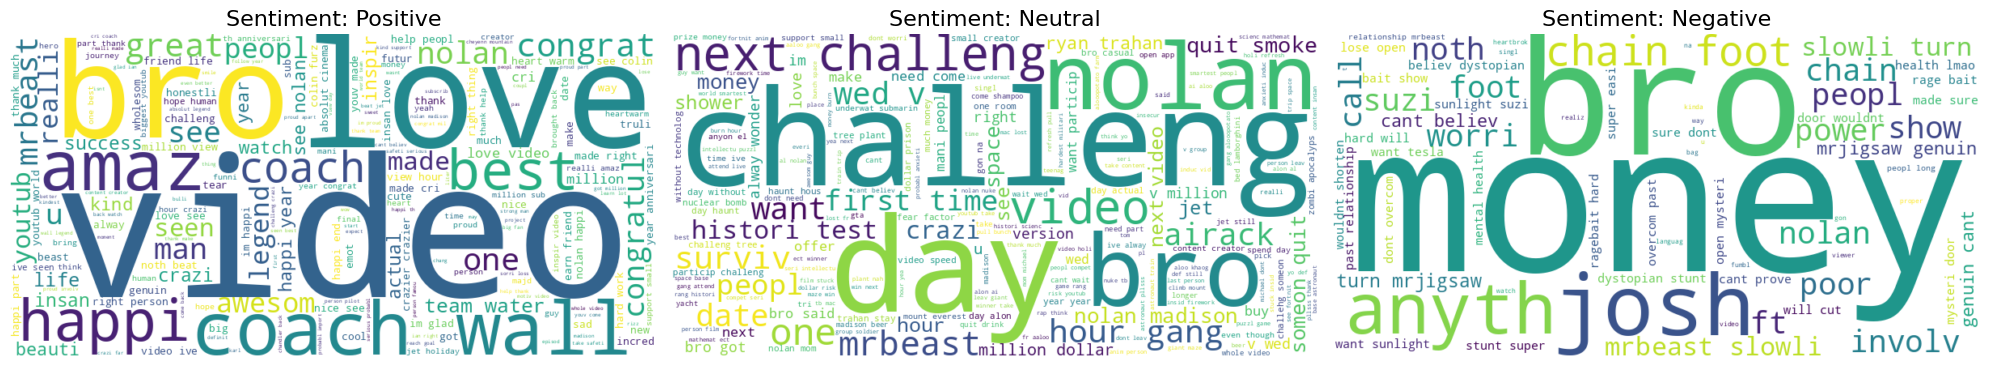

In [11]:
plt.figure(figsize=(20, 10))

for i, sentiment in enumerate(sentiments, 1):
    text = ' '.join(df[df['Sentiment'] == sentiment]['ProcessedComments'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Sentiment: {sentiment}", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Classification

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['ProcessedComments'])

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (4315, 1538)


In [13]:
y = df['Sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

In [15]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

Naive Bayes Accuracy: 0.9035
Logistic Regression Accuracy: 0.9290
SVM Accuracy: 0.9699


In [16]:
best_model = SVC()
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral']))

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.73      0.85        15
    Positive       0.97      0.99      0.98       874
     Neutral       0.98      0.93      0.95       406

    accuracy                           0.97      1295
   macro avg       0.98      0.89      0.93      1295
weighted avg       0.97      0.97      0.97      1295



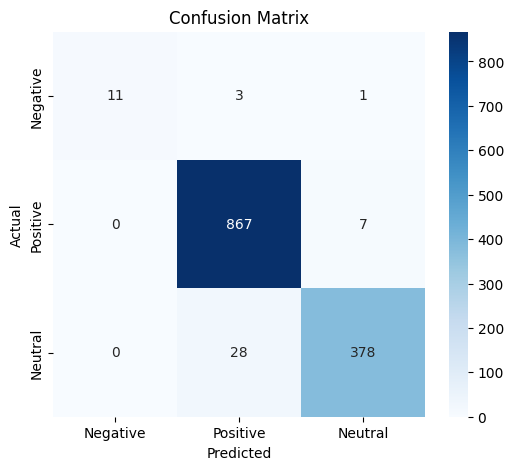

In [17]:
cm = confusion_matrix(y_test, y_pred)
classes = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()